## DESIGN OF FOUNDATIONS SUPPORTED BY RIGID INCLUSIONS

### Design Information

#### Provide the information below for design

In [1000]:
import numpy as np
# Input Parameters
column_size = (8/12, 30/12)  # Column dimensions (x, y) in ft
column_eccentricity = (0, 0)  # Eccentricity of column from center (x, y) in ft
column_centroid = (14/2-7.5/12, 9/2+17/12)  # center of the column in ft
pile_cap_thickness = 3+2/12 # Pile cap thickness in ft
pile_embedment = 1.0  # Depth of pile embedment in pile cap (ft)
soil_depth_above = 2.0  # Soil depth above pile cap (ft)
soil_density =  0 # Soil density in pcf
concrete_density = 0  # Concrete density in pcf
concrete_strength_psi = 3000
column_location = "interior" #edge/interior/corner
lambda_factor = 1.0
pile_cap_shear_depth = 3+2/12 - 3/12 - 9/8/12 - 9/8/2/12 # Effective shear depth (ft)

#### Provide information for rigid inclusions

In [1001]:
# Pile Properties
pile_shape = "square"  # Either "square" or "circular"
pile_size = 0.833  # Pile size (ft)
max_pile_compression = 120  # Max pile resistance in compression (kips)
max_pile_tension = 120  # Max pile resistance in tension (kips)

#### Provide loads on the supported column

In [1002]:
# Column Loads (kips and kip-ft)
Fx, Fy, Fz = 0, 0.0, -600*1.29  # Forces in kips
Mx, My = 0, 0  # Moments in kip-ft

#### Provide rigid inclusion layout

In [1003]:
# Pile Layout (x, y coordinates in ft) - measured from bottom-left corner
pile_layout = np.array([
    [3, 2.5],  [11, 2.5],   #[11.75, 3.5],     [19.25, 4],    [24.75,4],     [30.25,4],     [35.75,4],     [41.25,4],
    [7, 4.5],  # [6.5, 8.25],   [10, 8.25],   [13.5,8],    [24.75,8],     [30.25,8],     [35.75,8],     [41.25,8],
    [3, 6.5],  [11, 6.5],   #[11.75, 13],     [19.25,12],    [24.75,12],     [30.25,12],     [35.75,12],     [41.25,12]
])  # (ft)

#### Provide foundation shape coordinates

In [1004]:
# Pile Cap Shape (Vertices of pile cap)
pile_cap_vertices = np.array([
    [0, 0-0.5], [14.0, 0-0.5], [14.0, 9.5], [0, 9.5]
])  # Square pile cap

### Sections for Shear and Moment Calculations

#### Sections for one-way shear

In [1005]:
# Section 1: Regular line (y = mx + c)
offset_1 = column_centroid[1] + column_size[1] / 2 + pile_cap_shear_depth
one_way_shear_1_line_type = 'regular'
one_way_shear_1_line_value = (0, offset_1)

# Section 2: Vertical line (x = c)
offset_2 = column_centroid[0] + column_size[0] / 2 + pile_cap_shear_depth
one_way_shear_2_line_type = 'vertical'
one_way_shear_2_line_value = (offset_2,)

#### Sections for one-way moment

In [1006]:
# Section 1: Regular line (y = mx + c)
offset_3 = column_centroid[1] + column_size[1] / 2
one_way_moment_1_line_type = 'regular'
one_way_moment_1_line_value = (0, offset_3)

# Section 2: Vertical line (x = c)
offset_4 = column_centroid[0] + column_size[0] / 2
one_way_moment_2_line_type = 'vertical'
one_way_moment_2_line_value = (offset_4,)

### Library Imports for Functionality

In [1007]:
import pandas as pd
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import split
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from pile_distribution_analyzer import (analyze_pile_distribution_with_reactions, calculate_moments_about_section_line)
from weight_calculator import calculate_concrete_soil_weight
from shear_polygon_analysis import analyze_shear_polygon_reactions
from polygon_splitter import split_polygon_by_line
from visualization import plot_foundation_analysis
from design import calculate_area_of_steel
from design import calculate_punching_shear_capacity


### Check to Verify All Rigid Inclusions are Within Foundation

In [1008]:
# Verify all piles are within the pile cap boundary
min_x, min_y = np.min(pile_cap_vertices, axis=0)
max_x, max_y = np.max(pile_cap_vertices, axis=0)

for i, (px, py) in enumerate(pile_layout):
    if not (min_x <= px <= max_x and min_y <= py <= max_y):
        raise ValueError(f"Pile {i+1} at ({px}, {py}) is outside the pile cap!")

### Calculations for Self-weight of Foundation and Soil

In [1009]:
# Compute Self-weight of Pile Cap and Soil
pile_cap_volume = Polygon(pile_cap_vertices).area * pile_cap_thickness  # ft³
pile_cap_weight = (pile_cap_volume * concrete_density) / 1000  # kips

soil_volume = Polygon(pile_cap_vertices).area * soil_depth_above  # ft³
soil_weight = (soil_volume * soil_density) / 1000  # kips

# Deduct pile embedment weight
pile_embedment_weight = (pile_embedment * pile_size**2 * len(pile_layout) * concrete_density) / 1000  # kips
total_weight = pile_cap_weight + soil_weight - pile_embedment_weight

### Calculations for Reactions on Each Rigid Inclusion

#### Centroid of all rigid inclusions

In [1010]:
# Compute centroid of pile locations
pile_centroid = np.mean(pile_layout, axis=0)

#### Load adjustment for column eccentricity

In [1011]:
# Adjust loads for eccentricity
Mx_adj = Mx + Fz * column_eccentricity[1]  # Moment about x
My_adj = My - Fz * column_eccentricity[0]  # Moment about y

#### Equilibrium equations

In [1012]:
# Formulating Equilibrium Equations
num_piles = len(pile_layout)
A = np.zeros((3, num_piles))  # 3 equations (ΣFz=0, ΣMx=0, ΣMy=0)

# Right-hand side of the system of equations (Fix My sign)
b = np.array([-Fz + total_weight, -Mx_adj, My_adj])  # <-- FIX HERE

for i, (px, py) in enumerate(pile_layout):
    A[0, i] = 1  # ΣFz = 0
    A[1, i] = py - pile_centroid[1]  # ΣMx = 0 (Moment arm about x-axis)
    A[2, i] = px - pile_centroid[0]  # ΣMy = 0 (Moment arm about y-axis)

# Solve for reactions using least squares (in case of near-singular matrices)
reactions, _, _, _ = np.linalg.lstsq(A, b.reshape(-1, 1), rcond=None)

#### Checking all rigid inclusions are within their capacity

In [1013]:
# Ensure piles are within capacity
for i, R in enumerate(reactions.flatten()):
    if R > max_pile_compression:
        print(f"WARNING: Pile {i+1} exceeds max compression ({R:.2f} > {max_pile_compression} kips)")
    if R < -max_pile_tension:
        print(f"WARNING: Pile {i+1} exceeds max tension ({abs(R):.2f} > {max_pile_tension} kips)")

#### Results for reactions on rigid inclusions

In [1014]:
# Display Results
results = pd.DataFrame({
    "Pile": np.arange(1, num_piles + 1),
    "X (ft)": pile_layout[:, 0],
    "Y (ft)": pile_layout[:, 1],
    "Reaction (kips)": reactions.flatten()
})

print("\nPile Reactions:\n", results)


Pile Reactions:
    Pile  X (ft)  Y (ft)  Reaction (kips)
0     1     3.0     2.5            154.8
1     2    11.0     2.5            154.8
2     3     7.0     4.5            154.8
3     4     3.0     6.5            154.8
4     5    11.0     6.5            154.8


### One-way Shear Calculations

#### Calculations for split areas

In [1015]:
# Section 1: Function returns: area_above, area_below, first_area_moment_above, first_area_moment_below
area_above, area_below, area_moment_above, area_moment_below = split_polygon_by_line(
    pile_cap_vertices, one_way_shear_1_line_type, one_way_shear_1_line_value
)

print(f"Areas above the line 1: {area_above:.2f} sq.ft.")
print(f"Areas below the line 1: {area_below:.2f} sq.ft.")

area_B = min(area_above, area_below)
print(f"\nArea for Section 1 (one-way shear): {area_B:.2f} sq.ft.")

area_right, area_left, area_moment_right, area_moment_left = split_polygon_by_line(
    pile_cap_vertices, one_way_shear_2_line_type, one_way_shear_2_line_value
)

print(f"\nAreas to the right of the line 2: {area_right:.2f} sq.ft.")
print(f"Areas to the left of the line 2: {area_left:.2f} sq.ft.")

area_A = min(area_right, area_left)
print(f"\nArea for Section 2 (one-way shear): {area_A:.2f} sq.ft.")

Polygon not split!
Areas above the line 1: 140.00 sq.ft.
Areas below the line 1: 0.00 sq.ft.

Area for Section 1 (one-way shear): 0.00 sq.ft.

Areas to the right of the line 2: 45.16 sq.ft.
Areas to the left of the line 2: 94.84 sq.ft.

Area for Section 2 (one-way shear): 45.16 sq.ft.


#### Calculations for soil and concrete weights

In [1016]:
# Section 1
concrete_wt_B, soil_wt_B = calculate_concrete_soil_weight(
    area_B,
    pile_cap_thickness,
    soil_depth_above,
    concrete_density,
    soil_density
)

print(f"Concrete weight over {area_B:.3f} sq.ft.: {concrete_wt_B:.3f} kips")
print(f"Soil weight over {area_B:.3f} sq.ft.: {soil_wt_B:.3f} kips")

# Section 2
concrete_wt_A, soil_wt_A = calculate_concrete_soil_weight(
    area_A,
    pile_cap_thickness,
    soil_depth_above,
    concrete_density,
    soil_density
)

print(f"\nConcrete weight over {area_A:.3f} sq.ft.: {concrete_wt_A:.3f} kips")
print(f"Soil weight over {area_A:.3f} sq.ft.: {soil_wt_A:.3f} kips")

Concrete weight over 0.000 sq.ft.: 0.000 kips
Soil weight over 0.000 sq.ft.: 0.000 kips

Concrete weight over 45.156 sq.ft.: 0.000 kips
Soil weight over 45.156 sq.ft.: 0.000 kips


#### Calculations for pile reactions over the split areas

In [1017]:
# -----------------------------------
# Section 1: Analyze pile distribution with reactions 
# -----------------------------------
(
    area_above_1, area_below_1,
    piles_above_1, piles_below_1,
    intersected_area_above_1, intersected_area_below_1,
    intersected_piles_1,
    total_reaction_above_1, total_reaction_below_1,
    intersected_pile_geoms_1
) = analyze_pile_distribution_with_reactions(
    polygon_vertices=pile_cap_vertices,
    line_type=one_way_shear_1_line_type,
    line_value=one_way_shear_1_line_value,
    pile_layout=pile_layout,
    pile_size=pile_size,
    pile_reactions=reactions
)

# -----------------------------------
# Print results
# -----------------------------------
print(f"\n=== Areas (Section 1)===")
print(f"Total pile area above line 1: {area_above_1:.2f} sq.ft.")
print(f"Total pile area below line 1: {area_below_1:.2f} sq.ft.")

print(f"\n=== Piles (Section 1) ===")
print(f"Piles above line 1: {piles_above_1}")
print(f"Piles below line 1: {piles_below_1}")

print(f"\n=== Intersected Piles  (Section 1) ===")
print(f"Intersected piles: {intersected_piles_1}")
print(f"Intersected areas above line 1: {intersected_area_above_1:.2f} sq.ft.")
print(f"Intersected areas below line 1: {intersected_area_below_1:.2f} sq.ft.")

print(f"\n=== Reactions  (Section 1) ===")
print(f"Total reaction above line 1: {total_reaction_above_1:.2f} kips")
print(f"Total reaction below line 1: {total_reaction_below_1:.2f} kips")

# -----------------------------------
# Section 2: Analyze pile distribution with reactions 
# -----------------------------------
(
    area_above_2, area_below_2,
    piles_above_2, piles_below_2,
    intersected_area_above_2, intersected_area_below_2,
    intersected_piles_2,
    total_reaction_above_2, total_reaction_below_2,
    intersected_pile_geoms_2
) = analyze_pile_distribution_with_reactions(
    polygon_vertices=pile_cap_vertices,
    line_type=one_way_shear_2_line_type,
    line_value=one_way_shear_2_line_value,
    pile_layout=pile_layout,
    pile_size=pile_size,
    pile_reactions=reactions
)

# -----------------------------------
# Print results
# -----------------------------------
print(f"\n=== Areas (Section 2)===")
print(f"Total pile area to the right of line 2: {area_above_2:.2f} sq.ft.")
print(f"Total pile area to the left of line 2: {area_below_2:.2f} sq.ft.")

print(f"\n=== Piles (Section 2) ===")
print(f"Piles to the right of line 2: {piles_above_2}")
print(f"Piles to the left of line 2: {piles_below_2}")

print(f"\n=== Intersected Piles  (Section 2) ===")
print(f"Intersected piles: {intersected_piles_2}")
print(f"Intersected areas to the right of line 2: {intersected_area_above_2:.2f} sq.ft.")
print(f"Intersected areas to the left of line 2: {intersected_area_below_2:.2f} sq.ft.")

print(f"\n=== Reactions  (Section 2) ===")
print(f"Total reaction to the right of line 2: {total_reaction_above_2:.2f} kips")
print(f"Total reaction to the left of line 2: {total_reaction_below_2:.2f} kips")


=== Areas (Section 1)===
Total pile area above line 1: 0.00 sq.ft.
Total pile area below line 1: 3.47 sq.ft.

=== Piles (Section 1) ===
Piles above line 1: []
Piles below line 1: [1, 2, 3, 4, 5]

=== Intersected Piles  (Section 1) ===
Intersected piles: []
Intersected areas above line 1: 0.00 sq.ft.
Intersected areas below line 1: 0.00 sq.ft.

=== Reactions  (Section 1) ===
Total reaction above line 1: 0.00 kips
Total reaction below line 1: 774.00 kips

=== Areas (Section 2)===
Total pile area to the right of line 2: 1.39 sq.ft.
Total pile area to the left of line 2: 2.08 sq.ft.

=== Piles (Section 2) ===
Piles to the right of line 2: [2, 5]
Piles to the left of line 2: [1, 3, 4]

=== Intersected Piles  (Section 2) ===
Intersected piles: []
Intersected areas to the right of line 2: 0.00 sq.ft.
Intersected areas to the left of line 2: 0.00 sq.ft.

=== Reactions  (Section 2) ===
Total reaction to the right of line 2: 309.60 kips
Total reaction to the left of line 2: 464.40 kips


#### Calculations for net one-way shear

In [1018]:
one_way_shear_section_2 = total_reaction_above_2 - concrete_wt_A - soil_wt_A
one_way_shear_section_1 = total_reaction_above_1 - concrete_wt_B - soil_wt_B

print(f"\n=== One-Way Shear (kips)===")
print(f"Net one-way shear at Section 1: {one_way_shear_section_1:.2f} kips")
print(f"Net one-way shear at Section 2: {one_way_shear_section_2:.2f} kips")



=== One-Way Shear (kips)===
Net one-way shear at Section 1: 0.00 kips
Net one-way shear at Section 2: 309.60 kips


### One-way Moment Calculations

#### Calculations for split areas and first moment of areas

In [1019]:
# Section 1: Function returns: area_above, area_below, first_area_moment_above, first_area_moment_below
area_above_4, area_below_4, area_moment_above_4, area_moment_below_4 = split_polygon_by_line(
    pile_cap_vertices, one_way_moment_1_line_type, one_way_moment_1_line_value
)

print(f"Areas above the line 1: {area_above_4:.2f} sq.ft.")
print(f"Areas below the line 1: {area_below_4:.2f} sq.ft.")
print(f"First area moment above the line: {area_moment_above_4:.2f} sq.ft.-ft")
print(f"First area moment below the line: {area_moment_below_4:.2f} sq.ft.-ft\n")

area_D = min(area_above_4, area_below_4)
first_moment_area_D = min(area_moment_above_4, area_moment_below_4)
print(f"\nArea for Section 1 (one-way moment): {area_D:.2f} sq.ft.")
print(f"First moment of area for Section 1 (one-way moment): {first_moment_area_D:.2f} sq.ft.")

# Section 2: Function returns: area_above, area_below, first_area_moment_above, first_area_moment_below
area_above_3, area_below_3, area_moment_above_3, area_moment_below_3 = split_polygon_by_line(
    pile_cap_vertices, one_way_moment_2_line_type, one_way_moment_2_line_value
)

print(f"\nAreas right of the line 2: {area_above_3:.2f} sq.ft.")
print(f"Areas left the line 2: {area_below_3:.2f} sq.ft.")
print(f"First area moment right of the line: {area_moment_above_3:.2f} sq.ft.-ft")
print(f"First area moment left of the line: {area_moment_below_3:.2f} sq.ft.-ft\n")

area_C = min(area_above_3, area_below_3)
first_moment_area_C = min(area_moment_above_3, area_moment_below_3)
print(f"\nArea for Section 2 (one-way moment): {area_C:.2f} sq.ft.")
print(f"First moment of area for Section 2 (one-way moment): {first_moment_area_C:.2f} sq.ft.")

Areas above the line 1: 32.67 sq.ft.
Areas below the line 1: 107.33 sq.ft.
First area moment above the line: 38.11 sq.ft.-ft
First area moment below the line: 411.44 sq.ft.-ft


Area for Section 1 (one-way moment): 32.67 sq.ft.
First moment of area for Section 1 (one-way moment): 38.11 sq.ft.

Areas right of the line 2: 72.92 sq.ft.
Areas left the line 2: 67.08 sq.ft.
First area moment right of the line: 265.84 sq.ft.-ft
First area moment left of the line: 225.01 sq.ft.-ft


Area for Section 2 (one-way moment): 67.08 sq.ft.
First moment of area for Section 2 (one-way moment): 225.01 sq.ft.


#### Calculations for moment due to soil and concrete weights

In [1020]:
# Section 1
concrete_moment_D, soil_moment_D = calculate_concrete_soil_weight(
    first_moment_area_D,
    pile_cap_thickness,
    soil_depth_above,
    concrete_density,
    soil_density
)

print(f"\n=== Concrete and Soil Moments (Section 1) ===")
print(f"Concrete moment (over first moment of area) {first_moment_area_D:.3f} cu.ft.: {concrete_moment_D:.3f} kip-ft")
print(f"Soil moment (over first moment of area) {first_moment_area_D:.3f} cu.ft.: {soil_moment_D:.3f} kip-ft")

# Section 2
concrete_moment_C, soil_moment_C = calculate_concrete_soil_weight(
    first_moment_area_C,
    pile_cap_thickness,
    soil_depth_above,
    concrete_density,
    soil_density
)

print(f"\n=== Concrete and Soil Moments (Section 2) ===")
print(f"Concrete moment (over first moment of area) {first_moment_area_C:.3f} cu.ft.: {concrete_moment_C:.3f} kip-ft")
print(f"Soil moment (over first moment of area) {first_moment_area_C:.3f} cu.ft.: {soil_moment_C:.3f} kip-ft")


=== Concrete and Soil Moments (Section 1) ===
Concrete moment (over first moment of area) 38.111 cu.ft.: 0.000 kip-ft
Soil moment (over first moment of area) 38.111 cu.ft.: 0.000 kip-ft

=== Concrete and Soil Moments (Section 2) ===
Concrete moment (over first moment of area) 225.009 cu.ft.: 0.000 kip-ft
Soil moment (over first moment of area) 225.009 cu.ft.: 0.000 kip-ft


#### Calculations for moment due to pile reactions over the split areas

In [1021]:
# -----------------------------------
# Section 1: Analyze pile distribution with reactions 
# -----------------------------------
(
    area_above_4, area_below_4,
    piles_above_4, piles_below_4,
    intersected_area_above_4, intersected_area_below_4,
    intersected_piles_4,
    total_reaction_above_4, total_reaction_below_4,
    intersected_pile_geoms_4
) = analyze_pile_distribution_with_reactions(
    polygon_vertices=pile_cap_vertices,
    line_type=one_way_moment_1_line_type,
    line_value=one_way_moment_1_line_value,
    pile_layout=pile_layout,
    pile_size=pile_size,
    pile_reactions=reactions
)

# -----------------------------------
# Calculate moments about section line
# -----------------------------------
moment_above_4, moment_below_4 = calculate_moments_about_section_line(
    line_type=one_way_moment_1_line_type,
    line_value=one_way_moment_1_line_value,
    pile_layout=pile_layout,
    pile_reactions=reactions,
    piles_above=piles_above_4,
    piles_below=piles_below_4,
    intersected_pile_geoms=intersected_pile_geoms_4
)

# -----------------------------------
# Print results
# -----------------------------------
print(f"\n=== Areas (Section 1)===")
print(f"Total pile area above line 1: {area_above_4:.2f} sq.ft.")
print(f"Total pile area below line 1: {area_below_4:.2f} sq.ft.")

print(f"\n=== Piles (Section 1) ===")
print(f"Piles above line 1: {piles_above_4}")
print(f"Piles below line 1: {piles_below_4}")

print(f"\n=== Intersected Piles  (Section 1) ===")
print(f"Intersected piles: {intersected_piles_4}")
print(f"Intersected areas above line 1: {intersected_area_above_4:.2f} sq.ft.")
print(f"Intersected areas below line 1: {intersected_area_below_4:.2f} sq.ft.")

print(f"\n=== Reactions  (Section 1) ===")
print(f"Total reaction above line 1: {total_reaction_above_4:.2f} kips")
print(f"Total reaction below line 1: {total_reaction_below_4:.2f} kips")

print(f"\n=== Moments (Section 1) ===")
print(f"Moment above line: {moment_above_4:.2f} kip-ft")
print(f"Moment below line: {moment_below_4:.2f} kip-ft")



# -----------------------------------
# Section 2: Analyze pile distribution with reactions 
# -----------------------------------
(
    area_above_3, area_below_3,
    piles_above_3, piles_below_3,
    intersected_area_above_3, intersected_area_below_3,
    intersected_piles_3,
    total_reaction_above_3, total_reaction_below_3,
    intersected_pile_geoms_3
) = analyze_pile_distribution_with_reactions(
    polygon_vertices=pile_cap_vertices,
    line_type=one_way_moment_2_line_type,
    line_value=one_way_moment_2_line_value,
    pile_layout=pile_layout,
    pile_size=pile_size,
    pile_reactions=reactions
)

# -----------------------------------
# Calculate moments about section line
# -----------------------------------
moment_above_3, moment_below_3 = calculate_moments_about_section_line(
    line_type=one_way_moment_2_line_type,
    line_value=one_way_moment_2_line_value,
    pile_layout=pile_layout,
    pile_reactions=reactions,
    piles_above=piles_above_3,
    piles_below=piles_below_3,
    intersected_pile_geoms=intersected_pile_geoms_3
)

# -----------------------------------
# Print results
# -----------------------------------
print(f"\n=== Areas (Section 2)===")
print(f"Total pile area right of line 2: {area_above_3:.2f} sq.ft.")
print(f"Total pile area left of line 2: {area_below_3:.2f} sq.ft.")

print(f"\n=== Piles (Section 2) ===")
print(f"Piles right of line 2: {piles_above_3}")
print(f"Piles left of line 2: {piles_below_3}")

print(f"\n=== Intersected Piles  (Section 1) ===")
print(f"Intersected piles: {intersected_piles_3}")
print(f"Intersected areas right of line 2: {intersected_area_above_3:.2f} sq.ft.")
print(f"Intersected areas left of line 2: {intersected_area_below_3:.2f} sq.ft.")

print(f"\n=== Reactions  (Section 2) ===")
print(f"Total reaction right of line 2: {total_reaction_above_3:.2f} kips")
print(f"Total reaction left of line 2: {total_reaction_below_3:.2f} kips")

print(f"\n=== Moments (Section 2) ===")
print(f"Moment right of line: {moment_above_3:.2f} kip-ft")
print(f"Moment left of line: {moment_below_3:.2f} kip-ft")


=== Areas (Section 1)===
Total pile area above line 1: 0.00 sq.ft.
Total pile area below line 1: 3.47 sq.ft.

=== Piles (Section 1) ===
Piles above line 1: []
Piles below line 1: [1, 2, 3, 4, 5]

=== Intersected Piles  (Section 1) ===
Intersected piles: []
Intersected areas above line 1: 0.00 sq.ft.
Intersected areas below line 1: 0.00 sq.ft.

=== Reactions  (Section 1) ===
Total reaction above line 1: 0.00 kips
Total reaction below line 1: 774.00 kips

=== Moments (Section 1) ===
Moment above line: 0.00 kip-ft
Moment below line: 2064.00 kip-ft

=== Areas (Section 2)===
Total pile area right of line 2: 1.98 sq.ft.
Total pile area left of line 2: 1.49 sq.ft.

=== Piles (Section 2) ===
Piles right of line 2: [2, 5]
Piles left of line 2: [1, 4]

=== Intersected Piles  (Section 1) ===
Intersected piles: [3]
Intersected areas right of line 2: 0.59 sq.ft.
Intersected areas left of line 2: 0.10 sq.ft.

=== Reactions  (Section 2) ===
Total reaction right of line 2: 441.20 kips
Total reaction 

#### Calculations for net one-way moment

In [1022]:
one_way_moment_section_3 = moment_above_3 - concrete_moment_C - soil_moment_C
one_way_moment_section_4 = moment_above_4 - concrete_moment_D - soil_moment_D

print(f"\n=== One-Way Mooment (kip-ft)===")
print(f"Net one-way moment at Section 1: {one_way_moment_section_4:.2f} kip-ft")
print(f"Net one-way moment at Section 2: {one_way_moment_section_3:.2f} kip-ft")


area_of_steel_section_1 = calculate_area_of_steel(one_way_moment_section_4, pile_cap_shear_depth)
area_of_steel_section_2 = calculate_area_of_steel(one_way_moment_section_3, pile_cap_shear_depth)



=== One-Way Mooment (kip-ft)===
Net one-way moment at Section 1: 0.00 kip-ft
Net one-way moment at Section 2: 1375.30 kip-ft


### Two-way Shear Calculations

#### Calculations for total reaction outside two-way shear polygon

In [1023]:
# Total reaction outside punching shear polygon
result = analyze_shear_polygon_reactions(
    polygon_vertices=pile_cap_vertices,
    pile_layout=pile_layout,
    pile_size=pile_size,
    column_centroid=column_centroid,
    column_size=column_size,
    shear_depth=pile_cap_shear_depth,
    pile_reactions=reactions
)

(
    total_reaction_outside,
    shear_polygon_coords,
    shear_polygon_perimeter,
    inside_piles,
    outside_piles,
    intersecting_piles
) = result

print(f"Total reaction outside shear polygon: {total_reaction_outside:.2f} kip")
print(f"Shear polygon perimeter length: {shear_polygon_perimeter:.2f} ft")
print(f"Shear polygon coordinates: {shear_polygon_coords}\n")

print(f"Piles fully inside shear polygon: {inside_piles}")
print(f"Piles fully outside shear polygon: {outside_piles}")
print(f"Piles intersecting shear polygon: {intersecting_piles}")


Total reaction outside shear polygon: 619.20 kip
Shear polygon perimeter length: 17.44 ft
Shear polygon coordinates: [(4.653645833333334, 3.278645833333334), (4.653645833333334, 8.5546875), (8.096354166666666, 8.5546875), (8.096354166666666, 3.278645833333334), (4.653645833333334, 3.278645833333334)]

Piles fully inside shear polygon: [3]
Piles fully outside shear polygon: [1, 2, 4, 5]
Piles intersecting shear polygon: []


#### Calculations for punching shear capacity

In [1024]:
Vc = calculate_punching_shear_capacity(
    column_size,
    concrete_strength_psi ,
    pile_cap_shear_depth*12,
    shear_polygon_perimeter*12,
    lambda_factor,
    column_location, 
)
print(f"Punching shear capacity = {Vc:.3f} kips")
utilization_ratio = total_reaction_outside / Vc * 100
print(f"Punching shear utilization ratio = {utilization_ratio:.2f} %")

Punching shear capacity = 1145.393 kips
Punching shear utilization ratio = 54.06 %


### Summary of Shear and Moment Acting on Foundation

#### Analysis results

In [1025]:
print(f"\n=== One-Way Shear (kips)===")
print(f"Net one-way shear at Section 1: {one_way_shear_section_1:.2f} kips")
print(f"Net one-way shear at Section 2: {one_way_shear_section_2:.2f} kips")

print(f"\n=== One-Way Mooment (kip-ft)===")
print(f"Net one-way moment at Section 1: {one_way_moment_section_4:.2f} kip-ft")
print(f"Net one-way moment at Section 2: {one_way_moment_section_3:.2f} kip-ft")
print(f"Area of steel for Section 1: {area_of_steel_section_1:.3f} sq. in.")
print(f"Area of steel for Section 2: {area_of_steel_section_2:.3f} sq. in.")

print(f"\n=== Two-way Shear (kip)===")
print(f"Total reaction outside shear polygon: {total_reaction_outside:.2f} kip")
print(f"Punching shear capacity = {Vc:.3f} kips")
print(f"Punching shear utilization ratio = {utilization_ratio:.2f} %")



=== One-Way Shear (kips)===
Net one-way shear at Section 1: 0.00 kips
Net one-way shear at Section 2: 309.60 kips

=== One-Way Mooment (kip-ft)===
Net one-way moment at Section 1: 0.00 kip-ft
Net one-way moment at Section 2: 1375.30 kip-ft
Area of steel for Section 1: 0.000 sq. in.
Area of steel for Section 2: 11.468 sq. in.

=== Two-way Shear (kip)===
Total reaction outside shear polygon: 619.20 kip
Punching shear capacity = 1145.393 kips
Punching shear utilization ratio = 54.06 %


### Visualization

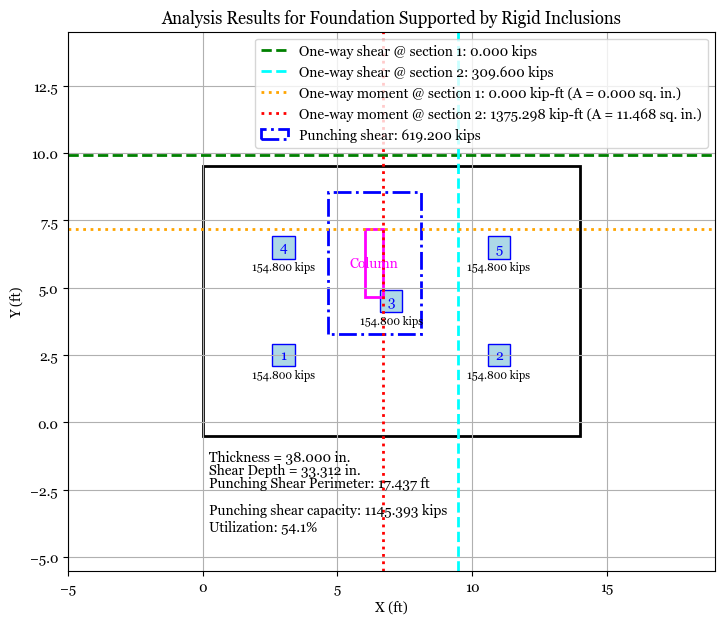

In [1026]:
plot_foundation_analysis(pile_cap_vertices,    pile_layout,    pile_size,    reactions,    column_size,    column_centroid,
    pile_cap_thickness,    pile_cap_shear_depth, one_way_shear_1_line_type,    one_way_shear_1_line_value,    one_way_shear_2_line_type,
    one_way_shear_2_line_value,    one_way_moment_1_line_type,    one_way_moment_1_line_value,    one_way_moment_2_line_type,
    one_way_moment_2_line_value,    one_way_shear_section_1,    one_way_shear_section_2,    one_way_moment_section_4,
    one_way_moment_section_3,    area_of_steel_section_1,    area_of_steel_section_2,    shear_polygon_coords,
    total_reaction_outside,    Vc,    utilization_ratio)
